In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [2]:
# Download the CIFAR10 data
train_ds = torchvision.datasets.CIFAR10(root="./datasets",download=True,train=True,transform=torchvision.transforms.ToTensor())
test_ds = torchvision.datasets.CIFAR10(root="./datasets",download=True,train=False,transform=torchvision.transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [3]:
train_ds[0][0].shape, train_ds[0][1]

(torch.Size([3, 32, 32]), 6)

In [4]:
# Create the dataloader (batched) from the dataset
train_dl = torch.utils.data.DataLoader(train_ds,batch_size=128)
test_dl = torch.utils.data.DataLoader(test_ds,batch_size=128)

In [5]:
# Defining the device that we are going to use for the training
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Function to train the neural network model for one epoch (one loop over all items in the train dataset)
def train_one_epoch(model, train_dl, crit,optim):
    avg_loss = 0
    corrects = 0
    total = 0
    # Set the model in train mode
    model.train()
    # Loop over each x,y pair in the batched dataloader
    for x,y in train_dl:
        # Set the gradients of all parameters to zero
        optim.zero_grad()
        # Send x and y to the device that is being used now
        x = x.to(dev)
        y = y.to(dev)
        # Forward
        o = model(x)
        corrects += (torch.argmax(o,axis=1) == y).sum()
        total += len(y)
        # Calculate the loss
        l = crit(o,y)
        avg_loss += l.item()
        # Backward (calculate the gradient of loss with respect to each parameter)
        l.backward()
        # Update each parameter using the calculated gradient of the loss
        optim.step()
    return avg_loss / len(train_dl), 100*(corrects/total)

# Function to test the model over all item in the test dataset
def test_model(model, test_dl, crit):
    avg_loss = 0
    corrects = 0
    total = 0
    # Set the model in evaluation mode
    model.eval()
    # Loop over each x,y pair in the batched dataloader
    for x,y in test_dl:
        # Send x and y to the device that is being used now
        x = x.to(dev)
        y = y.to(dev)
        # Forward
        o = model(x)
        corrects += (torch.argmax(o,axis=1) == y).sum()
        total += len(y)
        # Calculate the loss
        l = crit(o,y)
        avg_loss += l.item()
    return avg_loss / len(train_dl), 100*(corrects/total)

In [7]:
# Function to create a convolutional layer (conv + batchnorm + relu + pool)
def make_conv_layer(in_channels,out_channels,kernel_size=3,stride=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels,kernel_size=kernel_size,stride=stride),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2)
    )

In [8]:
# Defining our model (simple convolutional layer)
model = nn.Sequential(
    make_conv_layer(3,16,kernel_size=7), # N x 3 x 32 x 32 -> N x 16 x 13 x 13
    make_conv_layer(16,32), # N x 16 x 13 x 13 -> N x 32 x 5 x 5
    make_conv_layer(32,64), # N x 32 x 5 x 5 -> N x 64 x 1 x 1
    nn.Flatten(), # N x 64 x 1 x 1 -> N x 64
    nn.Linear(64,10).to(dev)
)

# Defining the optimizer to be used in the training
optim = torch.optim.SGD(model.parameters(),lr=0.1)
# Defining the loss function to be used
crit = nn.CrossEntropyLoss()

In [9]:
train_history = []
# Trainig the model for 5 epochs
for epoch in tqdm.tqdm(range(5)):
    train_loss, train_acc = train_one_epoch(model,train_dl,crit,optim)
    test_loss, test_acc = test_model(model, test_dl, crit)
    train_history.append([train_loss,train_acc,test_loss,test_acc])
    print(f"train_loss: {train_loss}, train_acc: {train_acc}, test_loss: {test_loss}, test_acc: {test_acc}")
train_history = np.array(train_history)

 20%|█████████████████                                                                    | 1/5 [00:32<02:09, 32.27s/it]

train_loss: 1.5614416565736542, train_acc: 43.55400085449219, test_loss: 0.47976076633424103, test_acc: 20.900001525878906


 40%|██████████████████████████████████                                                   | 2/5 [01:06<01:40, 33.63s/it]

train_loss: 1.3019790664658217, train_acc: 53.68400192260742, test_loss: 0.3725018793969508, test_acc: 36.65999984741211


 60%|███████████████████████████████████████████████████                                  | 3/5 [01:40<01:07, 33.59s/it]

train_loss: 1.1913966472496462, train_acc: 58.097999572753906, test_loss: 0.2955452630586941, test_acc: 48.59000015258789


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [02:14<00:33, 33.73s/it]

train_loss: 1.118664005375884, train_acc: 60.757999420166016, test_loss: 0.31153898836706606, test_acc: 46.91999816894531


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:48<00:00, 33.78s/it]

train_loss: 1.0632828102087426, train_acc: 62.965999603271484, test_loss: 0.26123825759838915, test_acc: 56.029998779296875


In [12]:
# If you have saved the model before
model.load_state_dict(torch.load("models/cifar10_cnn.ckpt"))

<All keys matched successfully>

prediction = 7, actual = 7


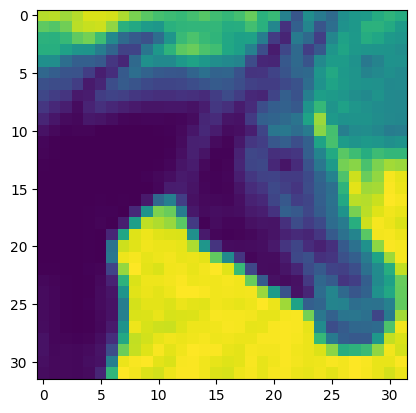

In [10]:
# Testing the model
x,y = test_ds[torch.randint(low=0,high=len(test_ds),size=(1,)).item()]
model.eval()
o = model(x.reshape((1,3,32,32)))
y_pred = torch.argmax(o,axis=1).item()
print(f"prediction = {y_pred}, actual = {y}")
plt.imshow(x[0])

In [11]:
# Saving our model
torch.save(model.state_dict(),"models/cifar10_cnn.ckpt")

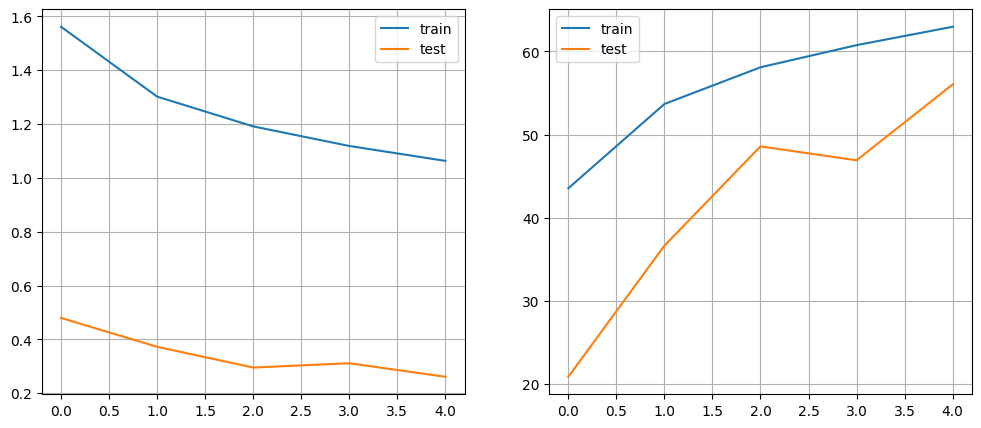

In [13]:
# Plot the loss evolution
fig,ax = plt.subplots(ncols=2,figsize=(12,5))
ax[0].plot(train_history[:,0],label="train")
ax[0].plot(train_history[:,2],label="test")
ax[0].grid()
ax[0].legend()
# Plot the accuracy evolution
ax[1].plot(train_history[:,1],label="train")
ax[1].plot(train_history[:,3],label="test")
ax[1].grid()
ax[1].legend()

In [15]:
# Defining a simple Residual block
class ResnetBlock(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=3,stride=2):
        super(ResnetBlock,self).__init__()
        self.direct = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=kernel_size,stride=stride),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels,out_channels,kernel_size=1),
            nn.BatchNorm2d(out_channels),
        )
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=kernel_size,stride=stride),
            nn.BatchNorm2d(out_channels),
        )
        self.relu = nn.ReLU(inplace=True)
    def forward(self,x):
        o = self.direct(x)
        s = self.shortcut(x)
        return self.relu(o + s)

In [16]:
# Defining our model (simple convolutional layer)
model = nn.Sequential(
    ResnetBlock(3,16,kernel_size=7), # N x 3 x 32 x 32 -> N x 16 x 13 x 13
    ResnetBlock(16,32), # N x 16 x 13 x 13 -> N x 32 x 6 x 6
    ResnetBlock(32,64), # N x 32 x 6 x 6 -> N x 64 x 2 x 2
    nn.Flatten(), # N x 64 x 2 x 2 -> N x 256
    nn.Linear(256,10).to(dev)
)

# Defining the optimizer to be used in the training
optim = torch.optim.SGD(model.parameters(),lr=0.1)
# Defining the loss function to be used
crit = nn.CrossEntropyLoss()

In [17]:
train_history = []
# Trainig the model for 5 epochs
for epoch in tqdm.tqdm(range(5)):
    train_loss, train_acc = train_one_epoch(model,train_dl,crit,optim)
    test_loss, test_acc = test_model(model, test_dl, crit)
    train_history.append([train_loss,train_acc,test_loss,test_acc])
    print(f"train_loss: {train_loss}, train_acc: {train_acc}, test_loss: {test_loss}, test_acc: {test_acc}")
train_history = np.array(train_history)

 20%|█████████████████                                                                    | 1/5 [00:29<01:58, 29.58s/it]

train_loss: 1.5718400054575536, train_acc: 42.604000091552734, test_loss: 0.37152421139085384, test_acc: 35.10000228881836


 40%|██████████████████████████████████                                                   | 2/5 [00:58<01:27, 29.31s/it]

train_loss: 1.3062887792392155, train_acc: 52.881996154785156, test_loss: 0.5209729390985826, test_acc: 26.690000534057617


 60%|███████████████████████████████████████████████████                                  | 3/5 [01:28<00:58, 29.49s/it]

train_loss: 1.1758079170570959, train_acc: 58.14200210571289, test_loss: 0.28563913664854396, test_acc: 50.77000427246094


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [01:58<00:29, 29.63s/it]

train_loss: 1.08137392830056, train_acc: 61.694000244140625, test_loss: 0.2756712573873418, test_acc: 52.7599983215332


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:28<00:00, 29.62s/it]

train_loss: 1.007336491514045, train_acc: 64.54199981689453, test_loss: 0.2551484714688547, test_acc: 55.94999694824219


In [20]:
# If you have saved the model before
model.load_state_dict(torch.load("models/cifar10_resnet.ckpt"))

<All keys matched successfully>

prediction = 4, actual = 2


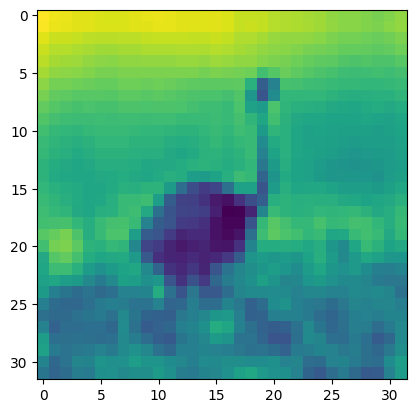

In [18]:
# Testing the model
x,y = test_ds[torch.randint(low=0,high=len(test_ds),size=(1,)).item()]
model.eval()
o = model(x.reshape((1,3,32,32)))
y_pred = torch.argmax(o,axis=1).item()
print(f"prediction = {y_pred}, actual = {y}")
plt.imshow(x[0])

In [19]:
# Saving our model
torch.save(model.state_dict(),"models/cifar10_resnet.ckpt")

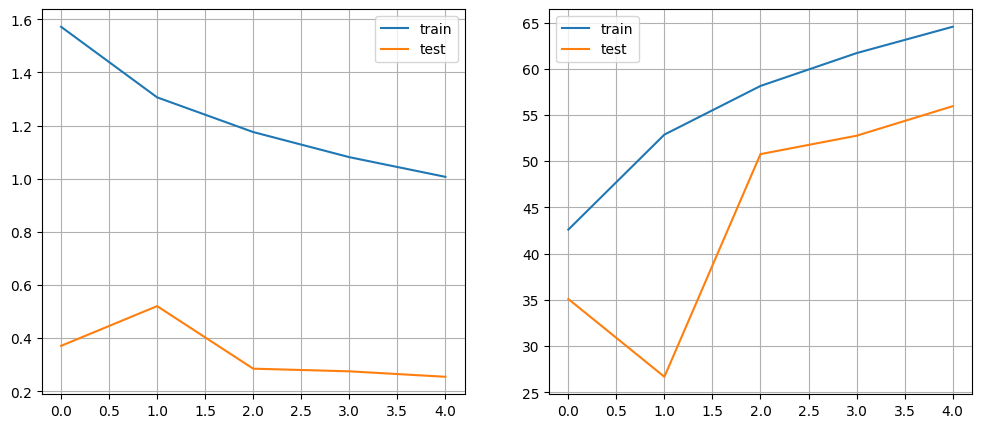

In [21]:
# Plot the loss evolution
fig,ax = plt.subplots(ncols=2,figsize=(12,5))
ax[0].plot(train_history[:,0],label="train")
ax[0].plot(train_history[:,2],label="test")
ax[0].grid()
ax[0].legend()
# Plot the accuracy evolution
ax[1].plot(train_history[:,1],label="train")
ax[1].plot(train_history[:,3],label="test")
ax[1].grid()
ax[1].legend()

In [22]:
# Download the CIFAR100 data
train_ds = torchvision.datasets.CIFAR100(root="./datasets",download=True,train=True,transform=torchvision.transforms.ToTensor())
test_ds = torchvision.datasets.CIFAR100(root="./datasets",download=True,train=False,transform=torchvision.transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [23]:
train_ds[0][0].shape, train_ds[0][1]

(torch.Size([3, 32, 32]), 19)

In [24]:
# Create the dataloader (batched) from the dataset
train_dl = torch.utils.data.DataLoader(train_ds,batch_size=128)
test_dl = torch.utils.data.DataLoader(test_ds,batch_size=128)

In [25]:
# Defining our model (simple convolutional layer)
model = nn.Sequential(
    make_conv_layer(3,16,kernel_size=7), # N x 3 x 32 x 32 -> N x 16 x 13 x 13
    make_conv_layer(16,32), # N x 16 x 13 x 13 -> N x 32 x 5 x 5
    make_conv_layer(32,64), # N x 32 x 5 x 5 -> N x 64 x 1 x 1
    nn.Flatten(), # N x 64 x 1 x 1 -> N x 64
    nn.Linear(64,100).to(dev)
)

# Defining the optimizer to be used in the training
optim = torch.optim.SGD(model.parameters(),lr=0.1)
# Defining the loss function to be used
crit = nn.CrossEntropyLoss()

In [26]:
train_history = []
# Trainig the model for 5 epochs
for epoch in tqdm.tqdm(range(5)):
    train_loss, train_acc = train_one_epoch(model,train_dl,crit,optim)
    test_loss, test_acc = test_model(model, test_dl, crit)
    train_history.append([train_loss,train_acc,test_loss,test_acc])
    print(f"train_loss: {train_loss}, train_acc: {train_acc}, test_loss: {test_loss}, test_acc: {test_acc}")
train_history = np.array(train_history)

 20%|█████████████████                                                                    | 1/5 [00:32<02:09, 32.40s/it]

train_loss: 3.9486272219196916, train_acc: 11.14799976348877, test_loss: 0.7996233820610339, test_acc: 11.230000495910645


 40%|██████████████████████████████████                                                   | 2/5 [01:04<01:36, 32.09s/it]

train_loss: 3.395164559869205, train_acc: 19.2239990234375, test_loss: 0.7933995937142531, test_acc: 12.760000228881836


 60%|███████████████████████████████████████████████████                                  | 3/5 [01:36<01:04, 32.22s/it]

train_loss: 3.151343245030669, train_acc: 23.435998916625977, test_loss: 0.7403717803223359, test_acc: 15.34000015258789


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [02:09<00:32, 32.59s/it]

train_loss: 2.996556691806335, train_acc: 26.350000381469727, test_loss: 0.6741660897384214, test_acc: 20.029998779296875


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:45<00:00, 33.06s/it]

train_loss: 2.8814780163338116, train_acc: 28.558000564575195, test_loss: 0.705564289751565, test_acc: 18.529998779296875


In [29]:
# If you have saved the model before
model.load_state_dict(torch.load("models/cifar100_cnn.ckpt"))

<All keys matched successfully>

prediction = 71, actual = 71


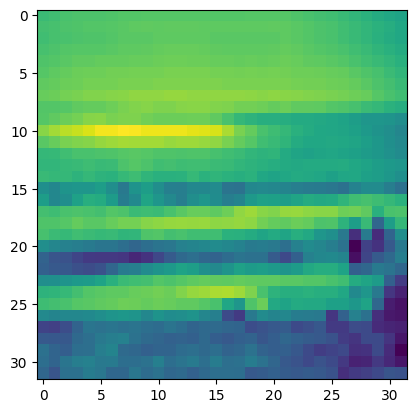

In [33]:
# Testing the model
x,y = test_ds[torch.randint(low=0,high=len(test_ds),size=(1,)).item()]
model.eval()
o = model(x.reshape((1,3,32,32)))
y_pred = torch.argmax(o,axis=1).item()
print(f"prediction = {y_pred}, actual = {y}")
plt.imshow(x[0])

In [28]:
# Saving our model
torch.save(model.state_dict(),"models/cifar100_cnn.ckpt")

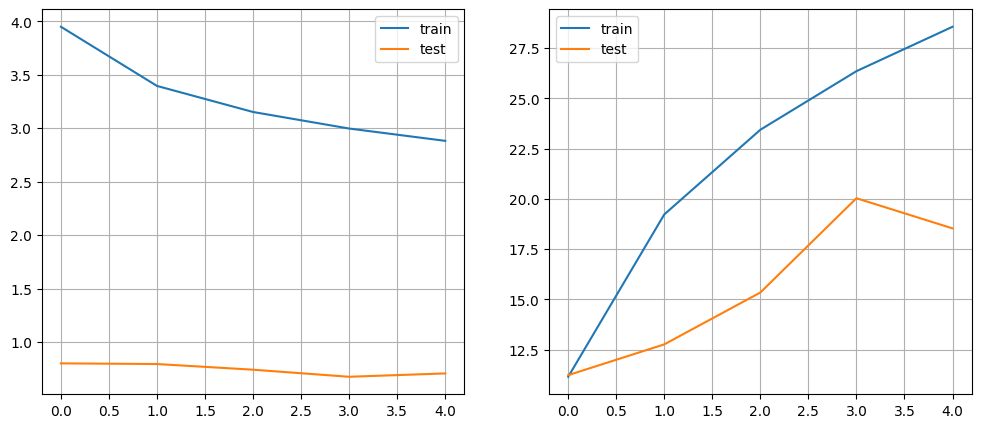

In [34]:
# Plot the loss evolution
fig,ax = plt.subplots(ncols=2,figsize=(12,5))
ax[0].plot(train_history[:,0],label="train")
ax[0].plot(train_history[:,2],label="test")
ax[0].grid()
ax[0].legend()
# Plot the accuracy evolution
ax[1].plot(train_history[:,1],label="train")
ax[1].plot(train_history[:,3],label="test")
ax[1].grid()
ax[1].legend()

In [35]:
# Defining our model (simple convolutional layer)
model = nn.Sequential(
    ResnetBlock(3,16,kernel_size=7), # N x 3 x 32 x 32 -> N x 16 x 13 x 13
    ResnetBlock(16,32), # N x 16 x 13 x 13 -> N x 32 x 6 x 6
    ResnetBlock(32,64), # N x 32 x 6 x 6 -> N x 64 x 2 x 2
    nn.Flatten(), # N x 64 x 1 x 1 -> N x 64
    nn.Linear(256,100).to(dev)
)

# Defining the optimizer to be used in the training
optim = torch.optim.SGD(model.parameters(),lr=0.1)
# Defining the loss function to be used
crit = nn.CrossEntropyLoss()

In [36]:
train_history = []
# Trainig the model for 5 epochs
for epoch in tqdm.tqdm(range(5)):
    train_loss, train_acc = train_one_epoch(model,train_dl,crit,optim)
    test_loss, test_acc = test_model(model, test_dl, crit)
    train_history.append([train_loss,train_acc,test_loss,test_acc])
    print(f"train_loss: {train_loss}, train_acc: {train_acc}, test_loss: {test_loss}, test_acc: {test_acc}")
train_history = np.array(train_history)

 20%|█████████████████                                                                    | 1/5 [00:29<01:58, 29.62s/it]

train_loss: 3.7846491586826647, train_acc: 12.853999137878418, test_loss: 0.7124536945996687, test_acc: 16.489999771118164


 40%|██████████████████████████████████                                                   | 2/5 [00:59<01:28, 29.61s/it]

train_loss: 3.2352145138908837, train_acc: 22.031999588012695, test_loss: 0.6984583453449142, test_acc: 19.030000686645508


 60%|███████████████████████████████████████████████████                                  | 3/5 [01:28<00:59, 29.59s/it]

train_loss: 2.9624839420513727, train_acc: 27.323999404907227, test_loss: 0.7137363292372135, test_acc: 19.040000915527344


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [01:58<00:29, 29.52s/it]

train_loss: 2.7738133836585237, train_acc: 31.142000198364258, test_loss: 0.7007046623912918, test_acc: 19.8799991607666


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:27<00:00, 29.45s/it]

train_loss: 2.6298727684313685, train_acc: 34.0099983215332, test_loss: 0.6690075452370412, test_acc: 22.39000129699707


In [39]:
# If you have saved the model before
model.load_state_dict(torch.load("models/cifar100_resnet.ckpt"))

<All keys matched successfully>

prediction = 26, actual = 26


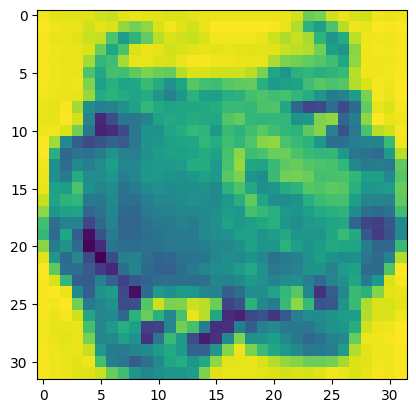

In [41]:
# Testing the model
x,y = test_ds[torch.randint(low=0,high=len(test_ds),size=(1,)).item()]
model.eval()
o = model(x.reshape((1,3,32,32)))
y_pred = torch.argmax(o,axis=1).item()
print(f"prediction = {y_pred}, actual = {y}")
plt.imshow(x[0])

In [38]:
# Saving our model
torch.save(model.state_dict(),"models/cifar100_resnet.ckpt")

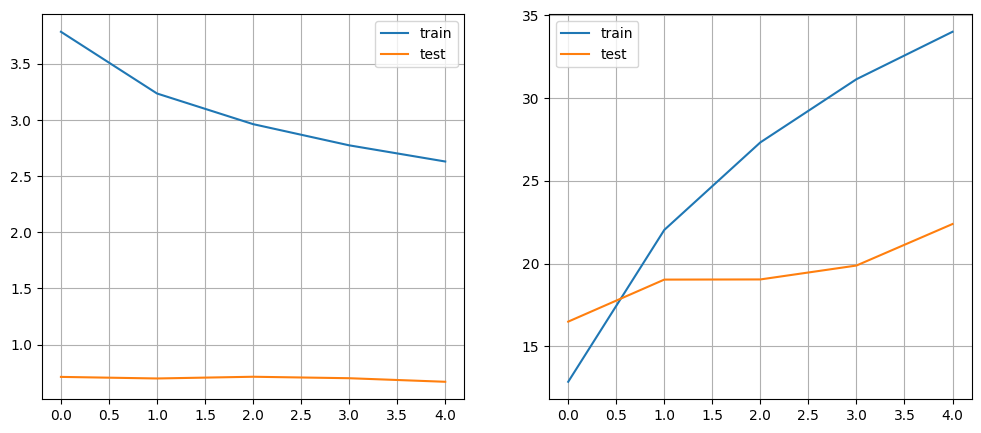

In [42]:
# Plot the loss evolution
fig,ax = plt.subplots(ncols=2,figsize=(12,5))
ax[0].plot(train_history[:,0],label="train")
ax[0].plot(train_history[:,2],label="test")
ax[0].grid()
ax[0].legend()
# Plot the accuracy evolution
ax[1].plot(train_history[:,1],label="train")
ax[1].plot(train_history[:,3],label="test")
ax[1].grid()
ax[1].legend()

In [ ]:
# # Download the data from kaggle
# !pip install kaggle
# !mkdir /root/.kaggle
# !mv kaggle.json /root/.kaggle
# !chmod 600 /root/.kaggle/kaggle.json
# !kaggle datasets download -d ayuraj/asl-dataset
# !unzip asl-dataset.zip
# !mv asl_dataset/asl_dataset asl_dataset/test_asl_dataset 
# !mv asl_dataset/test_asl_dataset  ./
# !mv asl_dataset train_asl_dataset
# !mkdir asl_dataset
# !mv ./train_asl_dataset ./asl_dataset/
# !mv ./test_asl_dataset ./asl_dataset/
# !mkdir datasets 
# !mv asl_dataset ./datasets/

In [45]:
# When loading an image we need to transform the image into a tensor and maybe do some other operations like 
# resizing, remap the values of the pixel using a normal distribution, etc
mytransform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64,64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0,0,0],[0.5,0.5,0.5],inplace=True),
])

In [46]:
# Create dataset based on images that are structured per classes into separated directories
train_ds = torchvision.datasets.ImageFolder(root="./datasets/asl_dataset/train_asl_dataset",transform=mytransform)
test_ds = torchvision.datasets.ImageFolder(root="./datasets/asl_dataset/test_asl_dataset",transform=mytransform)

In [47]:
train_ds[0][0].shape, len(train_ds.classes)

(torch.Size([3, 64, 64]), 36)

In [48]:
# Create our dataloaders (batched)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=128)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=128)

In [49]:
# Defining our model (simple convolutional layer)
model = nn.Sequential(
    make_conv_layer(3,16,kernel_size=7,stride=1), # N x 3 x 64 x 64 -> N x 16 x 29 x 29
    make_conv_layer(16,32,kernel_size=3,stride=1), # N x 16 x 29 x 29 -> N x 32 x 13 x 13
    make_conv_layer(32,64,kernel_size=3,stride=1), # N x 32 x 13 x 13 -> N x 64 x 5 x 5
    nn.Flatten(), # N x 64 x 5 x 5 -> N x 3200
    nn.Linear(1600,36).to(dev)
)

# Defining the optimizer to be used in the training
optim = torch.optim.SGD(model.parameters(),lr=0.01)
# Defining the loss function to be used
crit = nn.CrossEntropyLoss()

In [50]:
train_history = []
# Trainig the model for 15 epochs
for epoch in tqdm.tqdm(range(15)):
    train_loss, train_acc = train_one_epoch(model,train_dl,crit,optim)
    test_loss, test_acc = test_model(model, test_dl, crit)
    train_history.append([train_loss,train_acc,test_loss,test_acc])
    print(f"train_loss: {train_loss}, train_acc: {train_acc}, test_loss: {test_loss}, test_acc: {test_acc}")
train_history = np.array(train_history)

  7%|█████▌                                                                              | 1/15 [00:20<04:43, 20.22s/it]

train_loss: 5.363013219833374, train_acc: 2.107355833053589, test_loss: 3.9579914212226868, test_acc: 2.7833001613616943


 13%|███████████▏                                                                        | 2/15 [00:44<04:53, 22.59s/it]

train_loss: 4.021482765674591, train_acc: 8.429423332214355, test_loss: 3.5999173268675806, test_acc: 7.594433307647705


 20%|████████████████▊                                                                   | 3/15 [01:08<04:37, 23.16s/it]

train_loss: 3.0972362220287324, train_acc: 11.053677558898926, test_loss: 3.277294085919857, test_acc: 13.081510543823242


 27%|██████████████████████▍                                                             | 4/15 [01:31<04:16, 23.35s/it]

train_loss: 2.449266183376312, train_acc: 21.1530818939209, test_loss: 2.517575892806053, test_acc: 21.1530818939209


 33%|████████████████████████████                                                        | 5/15 [01:55<03:54, 23.41s/it]

train_loss: 1.8808701246976853, train_acc: 39.28429412841797, test_loss: 1.8135738223791122, test_acc: 38.33001708984375


 40%|█████████████████████████████████▌                                                  | 6/15 [02:22<03:41, 24.62s/it]

train_loss: 1.4482960015535356, train_acc: 55.029823303222656, test_loss: 1.5101855888962745, test_acc: 50.61629867553711


 47%|███████████████████████████████████████▏                                            | 7/15 [02:46<03:15, 24.43s/it]

train_loss: 1.181225088238716, train_acc: 62.70377731323242, test_loss: 1.3747402742505073, test_acc: 55.78528594970703


 53%|████████████████████████████████████████████▊                                       | 8/15 [03:10<02:49, 24.23s/it]

train_loss: 1.0371228128671646, train_acc: 66.56063842773438, test_loss: 1.4037213608622552, test_acc: 56.262428283691406


 60%|██████████████████████████████████████████████████▍                                 | 9/15 [03:33<02:22, 23.77s/it]

train_loss: 0.9335682794451714, train_acc: 69.3041763305664, test_loss: 1.5775334887206554, test_acc: 53.479122161865234


 67%|███████████████████████████████████████████████████████▎                           | 10/15 [03:56<01:57, 23.56s/it]

train_loss: 0.8398131020367146, train_acc: 72.7236557006836, test_loss: 1.4150860495865345, test_acc: 55.14910888671875


 73%|████████████████████████████████████████████████████████████▊                      | 11/15 [04:19<01:34, 23.51s/it]

train_loss: 0.7024537295103073, train_acc: 78.68787384033203, test_loss: 1.1378317542374135, test_acc: 62.26640319824219


 80%|██████████████████████████████████████████████████████████████████▍                | 12/15 [04:44<01:11, 23.82s/it]

train_loss: 0.6191795334219933, train_acc: 83.14115142822266, test_loss: 0.9606357380747795, test_acc: 67.2763442993164


 87%|███████████████████████████████████████████████████████████████████████▉           | 13/15 [05:08<00:48, 24.01s/it]

train_loss: 0.6043350115418434, train_acc: 83.14115142822266, test_loss: 1.1022654518485069, test_acc: 64.41352081298828


 93%|█████████████████████████████████████████████████████████████████████████████▍     | 14/15 [05:32<00:23, 23.89s/it]

train_loss: 0.6970935888588429, train_acc: 78.17097473144531, test_loss: 1.3157842818647623, test_acc: 62.425445556640625


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [05:56<00:00, 23.77s/it]

train_loss: 0.7641513474285603, train_acc: 78.05168914794922, test_loss: 0.9470756476745009, test_acc: 74.19483184814453


In [56]:
# If you have saved the model before
model.load_state_dict(torch.load("models/asl_dataset_cnn.ckpt"))

<All keys matched successfully>

prediction = 20, actual = 20


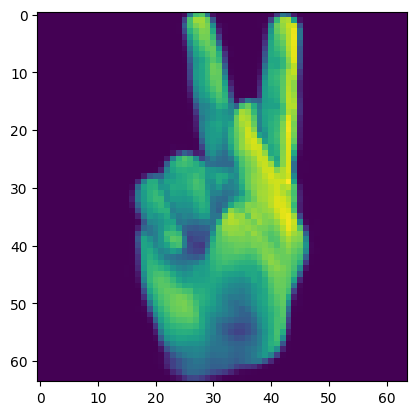

In [54]:
# Testing the model
x,y = test_ds[torch.randint(low=0,high=len(test_ds),size=(1,)).item()]
model.eval()
o = model(x.reshape((1,3,64,64)))
y_pred = torch.argmax(o,axis=1).item()
print(f"prediction = {y_pred}, actual = {y}")
plt.imshow(x[0])

In [55]:
# Saving our model
torch.save(model.state_dict(),"models/asl_dataset_cnn.ckpt")

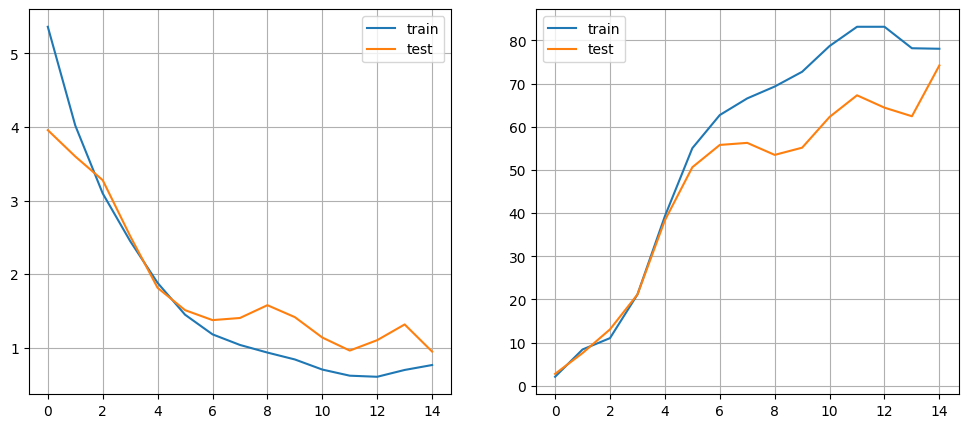

In [57]:
# Plot the loss evolution
fig,ax = plt.subplots(ncols=2,figsize=(12,5))
ax[0].plot(train_history[:,0],label="train")
ax[0].plot(train_history[:,2],label="test")
ax[0].grid()
ax[0].legend()
# Plot the accuracy evolution
ax[1].plot(train_history[:,1],label="train")
ax[1].plot(train_history[:,3],label="test")
ax[1].grid()
ax[1].legend()

In [58]:
# Defining our model (simple convolutional layer)
model = nn.Sequential(
    ResnetBlock(3,16,kernel_size=7), # N x 3 x 64 x 64 -> N x 16 x 29 x 29
    ResnetBlock(16,32), # N x 16 x 29 x 29 -> N x 32 x 14 x 14
    ResnetBlock(32,64), # N x 32 x 14 x 14 -> N x 64 x 6 x 6
    nn.Flatten(), # N x 64 x 6 x 6 -> N x 2304
    nn.Linear(64 * 6 * 6,36).to(dev)
)

# Defining the optimizer to be used in the training
optim = torch.optim.SGD(model.parameters(),lr=0.01)
# Defining the loss function to be used
crit = nn.CrossEntropyLoss()

In [59]:
train_history = []
# Trainig the model for 10 epochs
for epoch in tqdm.tqdm(range(10)):
    train_loss, train_acc = train_one_epoch(model,train_dl,crit,optim)
    test_loss, test_acc = test_model(model, test_dl, crit)
    train_history.append([train_loss,train_acc,test_loss,test_acc])
    print(f"train_loss: {train_loss}, train_acc: {train_acc}, test_loss: {test_loss}, test_acc: {test_acc}")
train_history = np.array(train_history)

 10%|████████▍                                                                           | 1/10 [00:22<03:23, 22.59s/it]

train_loss: 4.616236007213592, train_acc: 3.0616302490234375, test_loss: 3.362595635652542, test_acc: 3.896620035171509


 20%|████████████████▊                                                                   | 2/10 [00:44<02:56, 22.10s/it]

train_loss: 3.0555978417396545, train_acc: 14.512922286987305, test_loss: 2.418601195514202, test_acc: 26.36182975769043


 30%|█████████████████████████▏                                                          | 3/10 [01:06<02:35, 22.20s/it]

train_loss: 1.7140256136655807, train_acc: 49.82107162475586, test_loss: 2.3405360013246534, test_acc: 35.98409652709961


 40%|█████████████████████████████████▌                                                  | 4/10 [01:28<02:12, 22.01s/it]

train_loss: 1.1116189807653427, train_acc: 68.2306137084961, test_loss: 1.9946018628776074, test_acc: 46.08349609375


 50%|██████████████████████████████████████████                                          | 5/10 [01:50<01:50, 22.04s/it]

train_loss: 0.9840156033635139, train_acc: 72.3260498046875, test_loss: 1.467549315094948, test_acc: 54.47315979003906


 60%|██████████████████████████████████████████████████▍                                 | 6/10 [02:12<01:27, 21.91s/it]

train_loss: 0.7611910603940487, train_acc: 78.09144592285156, test_loss: 1.3243665799498558, test_acc: 60.039756774902344


 70%|██████████████████████████████████████████████████████████▊                         | 7/10 [02:34<01:06, 22.19s/it]

train_loss: 0.6299987517297267, train_acc: 81.98807525634766, test_loss: 1.0428899295628071, test_acc: 66.99800872802734


 80%|███████████████████████████████████████████████████████████████████▏                | 8/10 [02:56<00:44, 22.15s/it]

train_loss: 0.5082287520170212, train_acc: 87.3956298828125, test_loss: 0.912234540656209, test_acc: 70.6958236694336


 90%|███████████████████████████████████████████████████████████████████████████▌        | 9/10 [03:19<00:22, 22.25s/it]

train_loss: 0.3871791385114193, train_acc: 91.96819305419922, test_loss: 0.8730729341506958, test_acc: 75.46720123291016


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [03:42<00:00, 22.23s/it]

train_loss: 0.39893047139048576, train_acc: 89.4234619140625, test_loss: 1.213045981898904, test_acc: 62.70377731323242


In [64]:
# If you have saved the model before
model.load_state_dict(torch.load("models/asl_dataset_resnet.ckpt"))

<All keys matched successfully>

prediction = 7, actual = 7


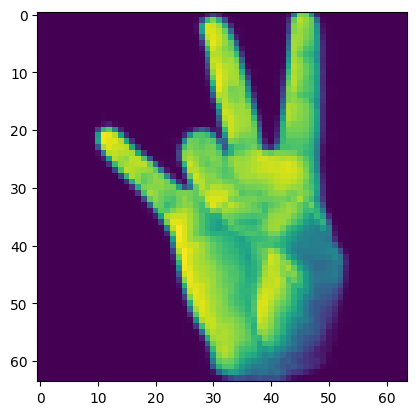

In [62]:
# Testing the model
x,y = test_ds[torch.randint(low=0,high=len(test_ds),size=(1,)).item()]
model.eval()
o = model(x.reshape((1,3,64,64)))
y_pred = torch.argmax(o,axis=1).item()
print(f"prediction = {y_pred}, actual = {y}")
plt.imshow(x[0])

In [63]:
# Saving our model
torch.save(model.state_dict(),"models/asl_dataset_resnet.ckpt")

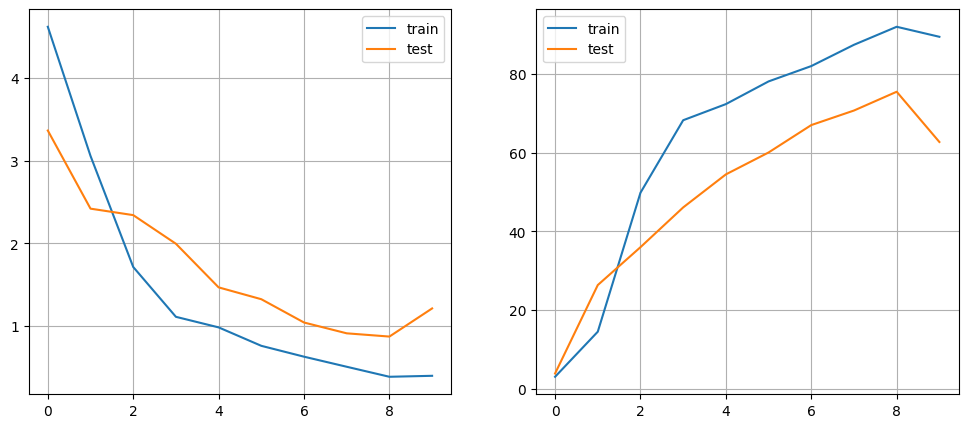

In [65]:
# Plot the loss evolution
fig,ax = plt.subplots(ncols=2,figsize=(12,5))
ax[0].plot(train_history[:,0],label="train")
ax[0].plot(train_history[:,2],label="test")
ax[0].grid()
ax[0].legend()
# Plot the accuracy evolution
ax[1].plot(train_history[:,1],label="train")
ax[1].plot(train_history[:,3],label="test")
ax[1].grid()
ax[1].legend()